In [1]:
import sys
sys.path.append('/home/nadzya/Apps/log-anomaly-detector/')

import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [6]:
import pandas as pd
import numpy as np 
import datetime
import json

from anomaly_detector.config import Configuration
from anomaly_detector.storage.mongodb_storage import MongoDBStorage
from anomaly_detector.storage.storage_attribute import MGStorageAttribute

from bson.json_util import dumps

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import re

In [203]:
def config():
    """Initialize configurations before testing."""
    cfg = Configuration()
    cfg.MG_HOST = "172.17.18.83"
    cfg.MG_PORT = 27017
    cfg.MG_CERT_DIR = ""
    cfg.MG_INPUT_DB = "anomalydb"
    cfg.MG_INPUT_COL = "utm_anomaly"
    cfg.HOSTNAME_INDEX = "hostname"
    cfg.DATETIME_INDEX = "timestamp"
    cfg.MG_USER = ''
    cfg.MG_PASSWORD = ''
    cfg.AGGR_VECTOR_LENGTH = 25
    cfg.AGGR_WINDOW = 5
    cfg.AGGR_EPS = 0.05
    cfg.AGGR_MIN_SAMPLES = 2
    return cfg

In [204]:
class DataCleaner:
    """Data cleaning utility functions."""

    @classmethod
    def _clean_message(cls, line):
        """Remove all none alphabetical characters from message strings."""
        words = list(re.findall("[a-zA-Z]+", line))
        return words
        
    @classmethod
    def _preprocess(cls, data):
        """Provide preprocessing for the data before running it through W2V and SOM."""
        def to_str(x):
            """Convert all non-str lists to string lists for Word2Vec."""
            ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
            return ret

        for col in data.columns:
            if col == "message":
                data[col] = data[col].apply(cls._clean_message)
            else:
                data[col] = data[col].apply(to_str)

        data = data.fillna("EMPTY")

    @classmethod
    def format_log(cls, config, es_dataset):
        """Format log will extract prefix out of the message."""
        if config.LOG_FORMATTER == "strip_prefix":
            for es_data in es_dataset:
                try:
                    if len(es_data['message'].split("] ")) > 1:
                        es_data["orig_message"] = es_data["message"]
                        es_data["message"] = es_data["message"].split("] ")[1]
                except Exception as ex:
                    logging.debug("Error {} in log formatter: {}".format(ex, config.ES_LOG_FORMATTER))

In [205]:
class MongoDBDataStorageSource(DataCleaner, MongoDBStorage):
    """MongoDB data source implementation."""

    NAME = "mg.source"

    def __init__(self, config):
        """Initialize mongodb storage backend."""
        self.config = config
        MongoDBStorage.__init__(self, config)

    def retrieve(self, storage_attribute: MGStorageAttribute):
        """Retrieve data from MongoDB."""

        mg_input_db = self.mg[self.config.MG_INPUT_DB]
        now = datetime.datetime.now()

        mg_data = mg_input_db[self.config.MG_INPUT_COL]

        if self.config.LOGSOURCE_HOSTNAME != 'localhost':
            query = {
                self.config.DATETIME_INDEX:  {
                    '$gte': now - datetime.timedelta(seconds=storage_attribute.time_range),
                    '$lt': now
                },
                self.config.HOSTNAME_INDEX: self.config.LOGSOURCE_HOSTNAME
            }
        else:
            query = {
                self.config.DATETIME_INDEX:  {
                    '$gte': now - datetime.timedelta(seconds=storage_attribute.time_range),
                    '$lt': now
                }
            }
        mg_data = mg_data.find(query).sort(self.config.DATETIME_INDEX, -1).limit(storage_attribute.number_of_entries)
        self.mg.close()

        if not mg_data.count():   # if it equials 0:
            return pandas.Dataframe(), mg_data

        mg_data = dumps(mg_data, sort_keys=False)

        mg_data_normalized = pd.DataFrame(pd.json_normalize(json.loads(mg_data)))
    
        self._preprocess(mg_data_normalized)

        return mg_data_normalized, json.loads(mg_data)

In [206]:
def get_lad_word2vec(config, df):
    w2v = W2VModel(config)
    w2v.create(df, config.AGGR_VECTOR_LENGTH, config.AGGR_WINDOW)
    return (w2v.one_vector(df), w2v.model["message"].wv)

In [207]:
def get_gensin_w2v(config, df):
    w2v = Word2Vec(sentences=list(df["message"]), size=config.AGGR_VECTOR_LENGTH, window=config.AGGR_WINDOW)
    
    vectors = []
    for x in list(df["message"]):
        temp = []
        for word in x:
            if word in w2v.wv:
                #print(len(w2v.wv[word]))
                temp.append(w2v.wv[word])
            else:
                temp.append(np.array([0]*config.AGGR_VECTOR_LENGTH))
        vectors.append(temp)
    return vectors

In [208]:
def log_words_to_vector(log_list):
    result = []
    log_array_transposed = np.array(log_list, dtype=object).transpose()
    for coord in log_array_transposed:
        result.append(np.mean(coord)) 
    return result

In [209]:
def all_logs_to_vectors(logs):
    result = []
    for log in logs:
        result.append(log_words_to_vector(log))
    return np.array(result)

In [210]:
def add_cluster_label_to_df(config, df, vectors):
    dbscan = DBSCAN(eps=config.AGGR_EPS, min_samples=cfg.AGGR_MIN_SAMPLES)
    clusters = dbscan.fit_predict(vectors)
    df["cluster"] = clusters
    return clusters

In [211]:
def aggregate_logs(df, df_json, clusters):
    aggregated = []
    for cluster in np.unique(clusters):
        messages = []
        for i in list(df.loc[df['cluster'] == cluster].index):
            messages.append(df_json[i]["message"])

        if cluster == -1:
            for msg in messages:
                aggregated.append((msg, 1, []))
                #aggregated.append(msg)
        else:
            splited_messages = [x.split() for x in messages]
            splited_transpose = [list(row) for row in zip(*splited_messages)]
            result_string = ""
            var_num = 0

            for x in splited_transpose:
                if len(set(x)) == 1:
                    result_string += x[0] + " "
                else:
                    result_string += "***" + " "

            msg_num = len(messages)
            aggregated.append((result_string[:-1], msg_num, messages))
            #aggregated.append(result_string[:-1])

    return aggregated

In [212]:
cfg = config()
mg = MongoDBDataStorageSource(cfg)
df, json_logs = mg.retrieve(MGStorageAttribute(30*86400, 1000))

Loading Configuration
Conecting to MongoDB without SSL/TLS encryption.
<ipython-input-205-5062e907c919>:37: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if not mg_data.count():   # if it equials 0:


In [213]:
df = pd.DataFrame(df["message"])
vectors = get_gensin_w2v(cfg, df)

consider setting layer size to a multiple of 4 for greater performance
collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 258 word types from a corpus of 14537 raw words and 392 sentences
Loading a fresh vocabulary
effective_min_count=5 retains 126 unique words (48% of original 258, drops 132)
effective_min_count=5 leaves 14237 word corpus (97% of original 14537, drops 300)
deleting the raw counts dictionary of 258 items
sample=0.001 downsamples 98 most-common words
downsampling leaves estimated 5983 word corpus (42.0% of prior 14237)
estimated required memory for 126 words and 25 dimensions: 88200 bytes
resetting layer weights
training model with 3 workers on 126 vocabulary and 25 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
job loop exiting, total 2 jobs
worker exiting, processed 0 jobs
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker 

In [214]:
mean_vectors = all_logs_to_vectors(vectors)

In [215]:
clusters = add_cluster_label_to_df(cfg, df, mean_vectors)
clusters

array([ 0,  0,  1,  1,  1,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  4,  4,  4,  1,  1,  1,  1,  1,  1,  1,  1,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  5,  5,  0,  0,  0,  0, -1,  6,  3,  6,
        6,  7,  7,  7,  7,  7,  7,  7,  7, -1, -1,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

Loaded backend module://matplotlib_inline.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


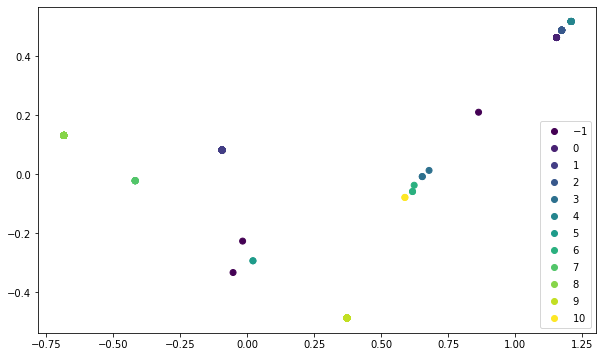

In [216]:
%pylab inline

pca = PCA(n_components=2, random_state=0)
data_2d_pca = pca.fit_transform(mean_vectors)

pylab.figure(figsize=(10, 6))
scat = pylab.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], c=list(df["cluster"]))
pylab.legend(*scat.legend_elements(num="auto"))

In [224]:
[" ".join(x) for x in list(df.loc[df["cluster"] == -1]["message"])]

['Dec U vectra standard DETECT detection category INFO type Novel External Destination Port hostname fax solidex minsk by currentIP dvchost threat certainty URL https detections detail id DestinationIP DestinationDomain sip telecom by DestinationPort Proto udp triaged False BytesSent BytesRcvd UTCTimeStart UTCTimeEnd',
 'date time devname SLX FG VM devid FGVM logid type utm subtype voip eventtype voip level information vd root eventtime tz session id epoch event id srcip src port dstip dst port proto src int port dst int port policy id profile default voip proto sip kind register action permit status succeeded duration dir session origin call id afa b a ec cb from sip sip telecom by to sip sip telecom by',
 'date time devname SLX FG VM devid FGVM logid type traffic subtype forward level notice vd root eventtime tz srcip srcname srcport srcintf port srcintfrole lan dstip dstname sip telecom by dstport dstintf port dstintfrole wan sessionid proto action accept policyid policytype policy 

In [218]:
aggregate_logs(df, json_logs, clusters)

[('<13>Dec  1 16:11:53 U22020000000877 vectra_standard -: DETECT [detection@41261 category="INFO" type="Novel External Destination Port" hostname="fax.solidex.minsk.by" currentIP="172.17.15.3" dvchost="172.17.18.39" threat="0" certainty="0" URL="https://172.17.18.39/detections/3320?detail_id\\=244128" DestinationIP="93.125.5.100" DestinationDomain="sip.telecom.by" DestinationPort="11062" Proto="udp" triaged="False" BytesSent="6182540" BytesRcvd="6193376" UTCTimeStart="2021-11-25 11:53:09" UTCTimeEnd="2021-12-01 13:11:17"]',
  1,
  []),
 ('<190>date=2021-11-30 time=23:27:21 devname="SLX-FG-VM-166" devid="FGVM010000010982" logid="0814044032" type="utm" subtype="voip" eventtype="voip" level="information" vd="root" eventtime=1638304041682242881 tz="+0300" session_id=188257872 epoch=0 event_id=14408 srcip=172.17.15.3 src_port=5060 dstip=93.125.5.100 dst_port=5060 proto=17 src_int="port4" dst_int="port2" policy_id=96 profile="default" voip_proto="sip" kind="register" action="permit" status="